In [1]:
##### Imports #####
# xcer_funcs contains functions for generating the X-CER circuits
# We also want to import the Qiskit IBM Provider
from xcer_funcs import generate_cer_circuits
from datalogger import DataLogger

from qiskit_ibm_provider import IBMProvider

# Import numpy and trueq
import numpy as np
import trueq as tq

import datetime
import random

from xcer_funcs import *

import ast

from qiskit_ibm_provider import IBMProvider
from datetime import datetime, timedelta

from sklearn.mixture import GaussianMixture

from scipy.optimize import minimize

In [151]:
# date_str = 20240115
# x, y = 268053, 0.0001, 0.0001
# x, y = 662030, 0.001, 0.001
# x, y = 17961, 0.001, 0.0001
# x = 820082, 0.001
# y = 354368, 0.001
# x, y = 785447, 0.001, 0.001

# date_str = 20240118

# x, y = 417855, 0.00005, 0.00005
# x, y = 604052, 0.0001, 0.0001

id = "417855"

date_str = "20240118"

import datetime
date_str = datetime.datetime.now().strftime("%Y%m%d")
dl = DataLogger(directory=f"./simulations/{date_str}/{id}/")
exp_info = dl.read_data()


 
 
cer_circuits = tq.load(F"./simulations/{date_str}/{id}/executed_circuits.tq")

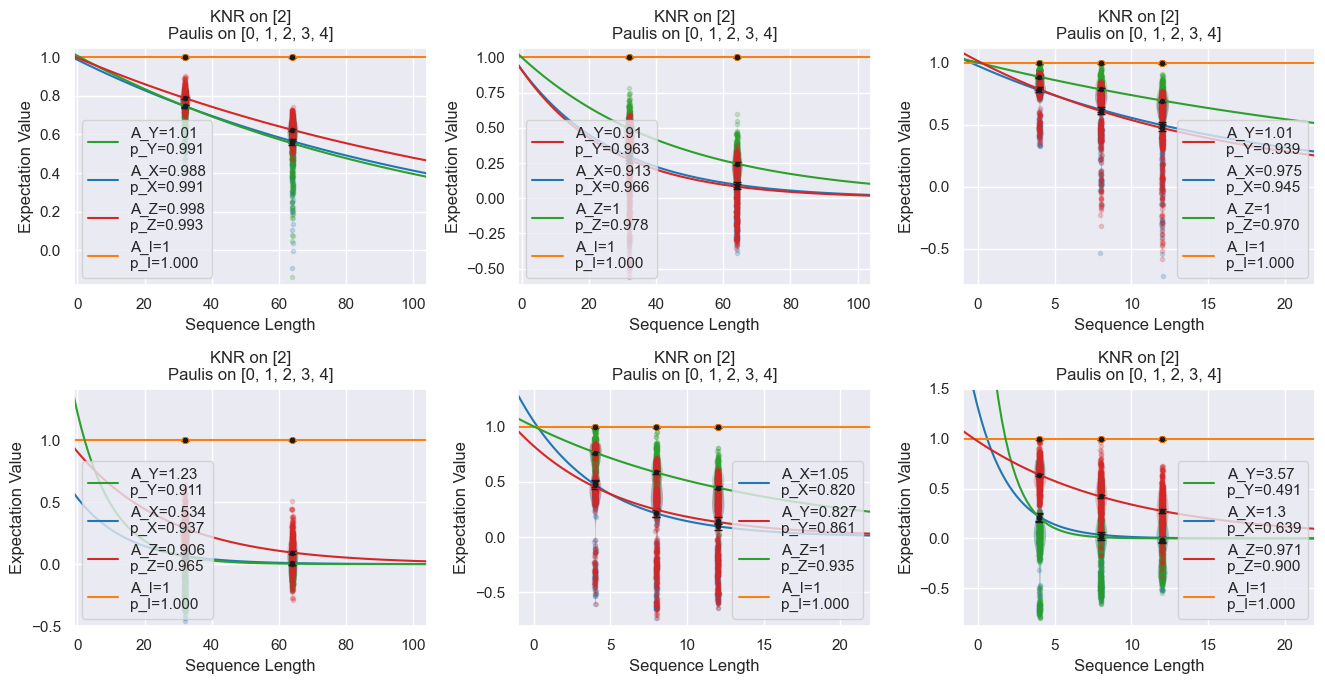

In [152]:
ancilla_index = 2
qubit_index = 2
cer_circuits.plot.raw(labels=(ancilla_index,))

In [153]:
dl.read_data()

{'id': '417855',
 'date': '2024-01-18',
 'batch_size': '300',
 'num_batches': '68',
 'num_circuits': '20250',
 'rep_len_tuples': '[(4, 4), (8, 4), (12, 4), (4, 8), (8, 8), (12, 8), (4, 12), (8, 12), (12, 12), (1, 32), (3, 32), (5, 32), (1, 64), (3, 64), (5, 64)]',
 'xangle_list': '[0.8760378172816414, 0.5208166693362641, 0.8094966231637625, 0.5427123628239925, 0.6380501536445139, 1.1936595281257936, 0.7347863839607435, 1.1255536891012812, 0.6724395886141857, 1.2520620110575198, 0.6040333485561422, 1.1899825371195427, 0.7369351885796678, 0.2668563939166795, 1.1042981250135353, 0.542584987630282, 1.0621118670660703, 0.7607023008142925, 0.3771421540206325, 0.7652259340683346, 0.8649549953393981, 0.7292641701609278, 0.6442039785188258, 1.5305349017028065, 1.2805386360901732, 0.8908761230713957, 0.7310992807108627, 0.7703865582288166, 0.6285808742442389, 0.6993473583791441, 0.7340883301975153, 0.5706971896956388, 0.9340549322200644, 0.837052779115866, 0.7617722778683085, 0.7607164782448901,

In [154]:
rep_len_tuples = ast.literal_eval(exp_info["rep_len_tuples"])

In [155]:
results_df = extract_results_dataframe(cer_circuits, ast.literal_eval(exp_info["rep_len_tuples"]), qubit_index=qubit_index)
avg_df = extract_avg_dataframe(results_df, ast.literal_eval(exp_info["rep_len_tuples"]), confidence=0.682)


In [156]:
fid_fit = []
rep_fit = []
length_fit = []
residual = []
decay = []
upper_bound_tw = 1.  # 1.00

# Fit to the full model
est_full, cov_full = curve_fit(f=error_model,
                               ydata=avg_df['fidelity'],
                               xdata=[avg_df['n_random_cycles'],
                                      avg_df['rep'], avg_df['Pauli_num']],  # [m, x]
                               sigma=avg_df['fidelity_std'],
                               p0=[1, 0, 0, 0]*3,
                               bounds=[[0, 0, 0, 0]*3,
                                       [1, 1, 1, upper_bound_tw]*3],
                               method='trf')

# Generate fitted fidelities (the stars)
for (rep, length) in rep_len_tuples:
    for pauli in ['X', 'Y', 'Z']:
        pauli_num = PAULITONUM[pauli]

        data_fid = avg_df[(avg_df['n_random_cycles'] == length)
                        & (avg_df['rep'] == rep)
                        & (avg_df['Pauli_num'] == pauli_num)]['fidelity']
        fit_fid = float(error_model([length, rep, [pauli_num]],
                                   *est_full
                                   ))
        fid_fit.append(fit_fid)
        residual.append(fit_fid-data_fid)
        rep_fit.append(rep)
        length_fit.append(length)
        decay.append(pauli)

# Generate a dataframe for the fitted fidelity values:
df_dict = {'fidelity': fid_fit,
           'rep': rep_fit,
           'n_random_cycles': length_fit,
           'Pauli': decay,
           'residual': residual}
df_fit_full = pd.DataFrame(data=df_dict)  # Corresponds to the stars

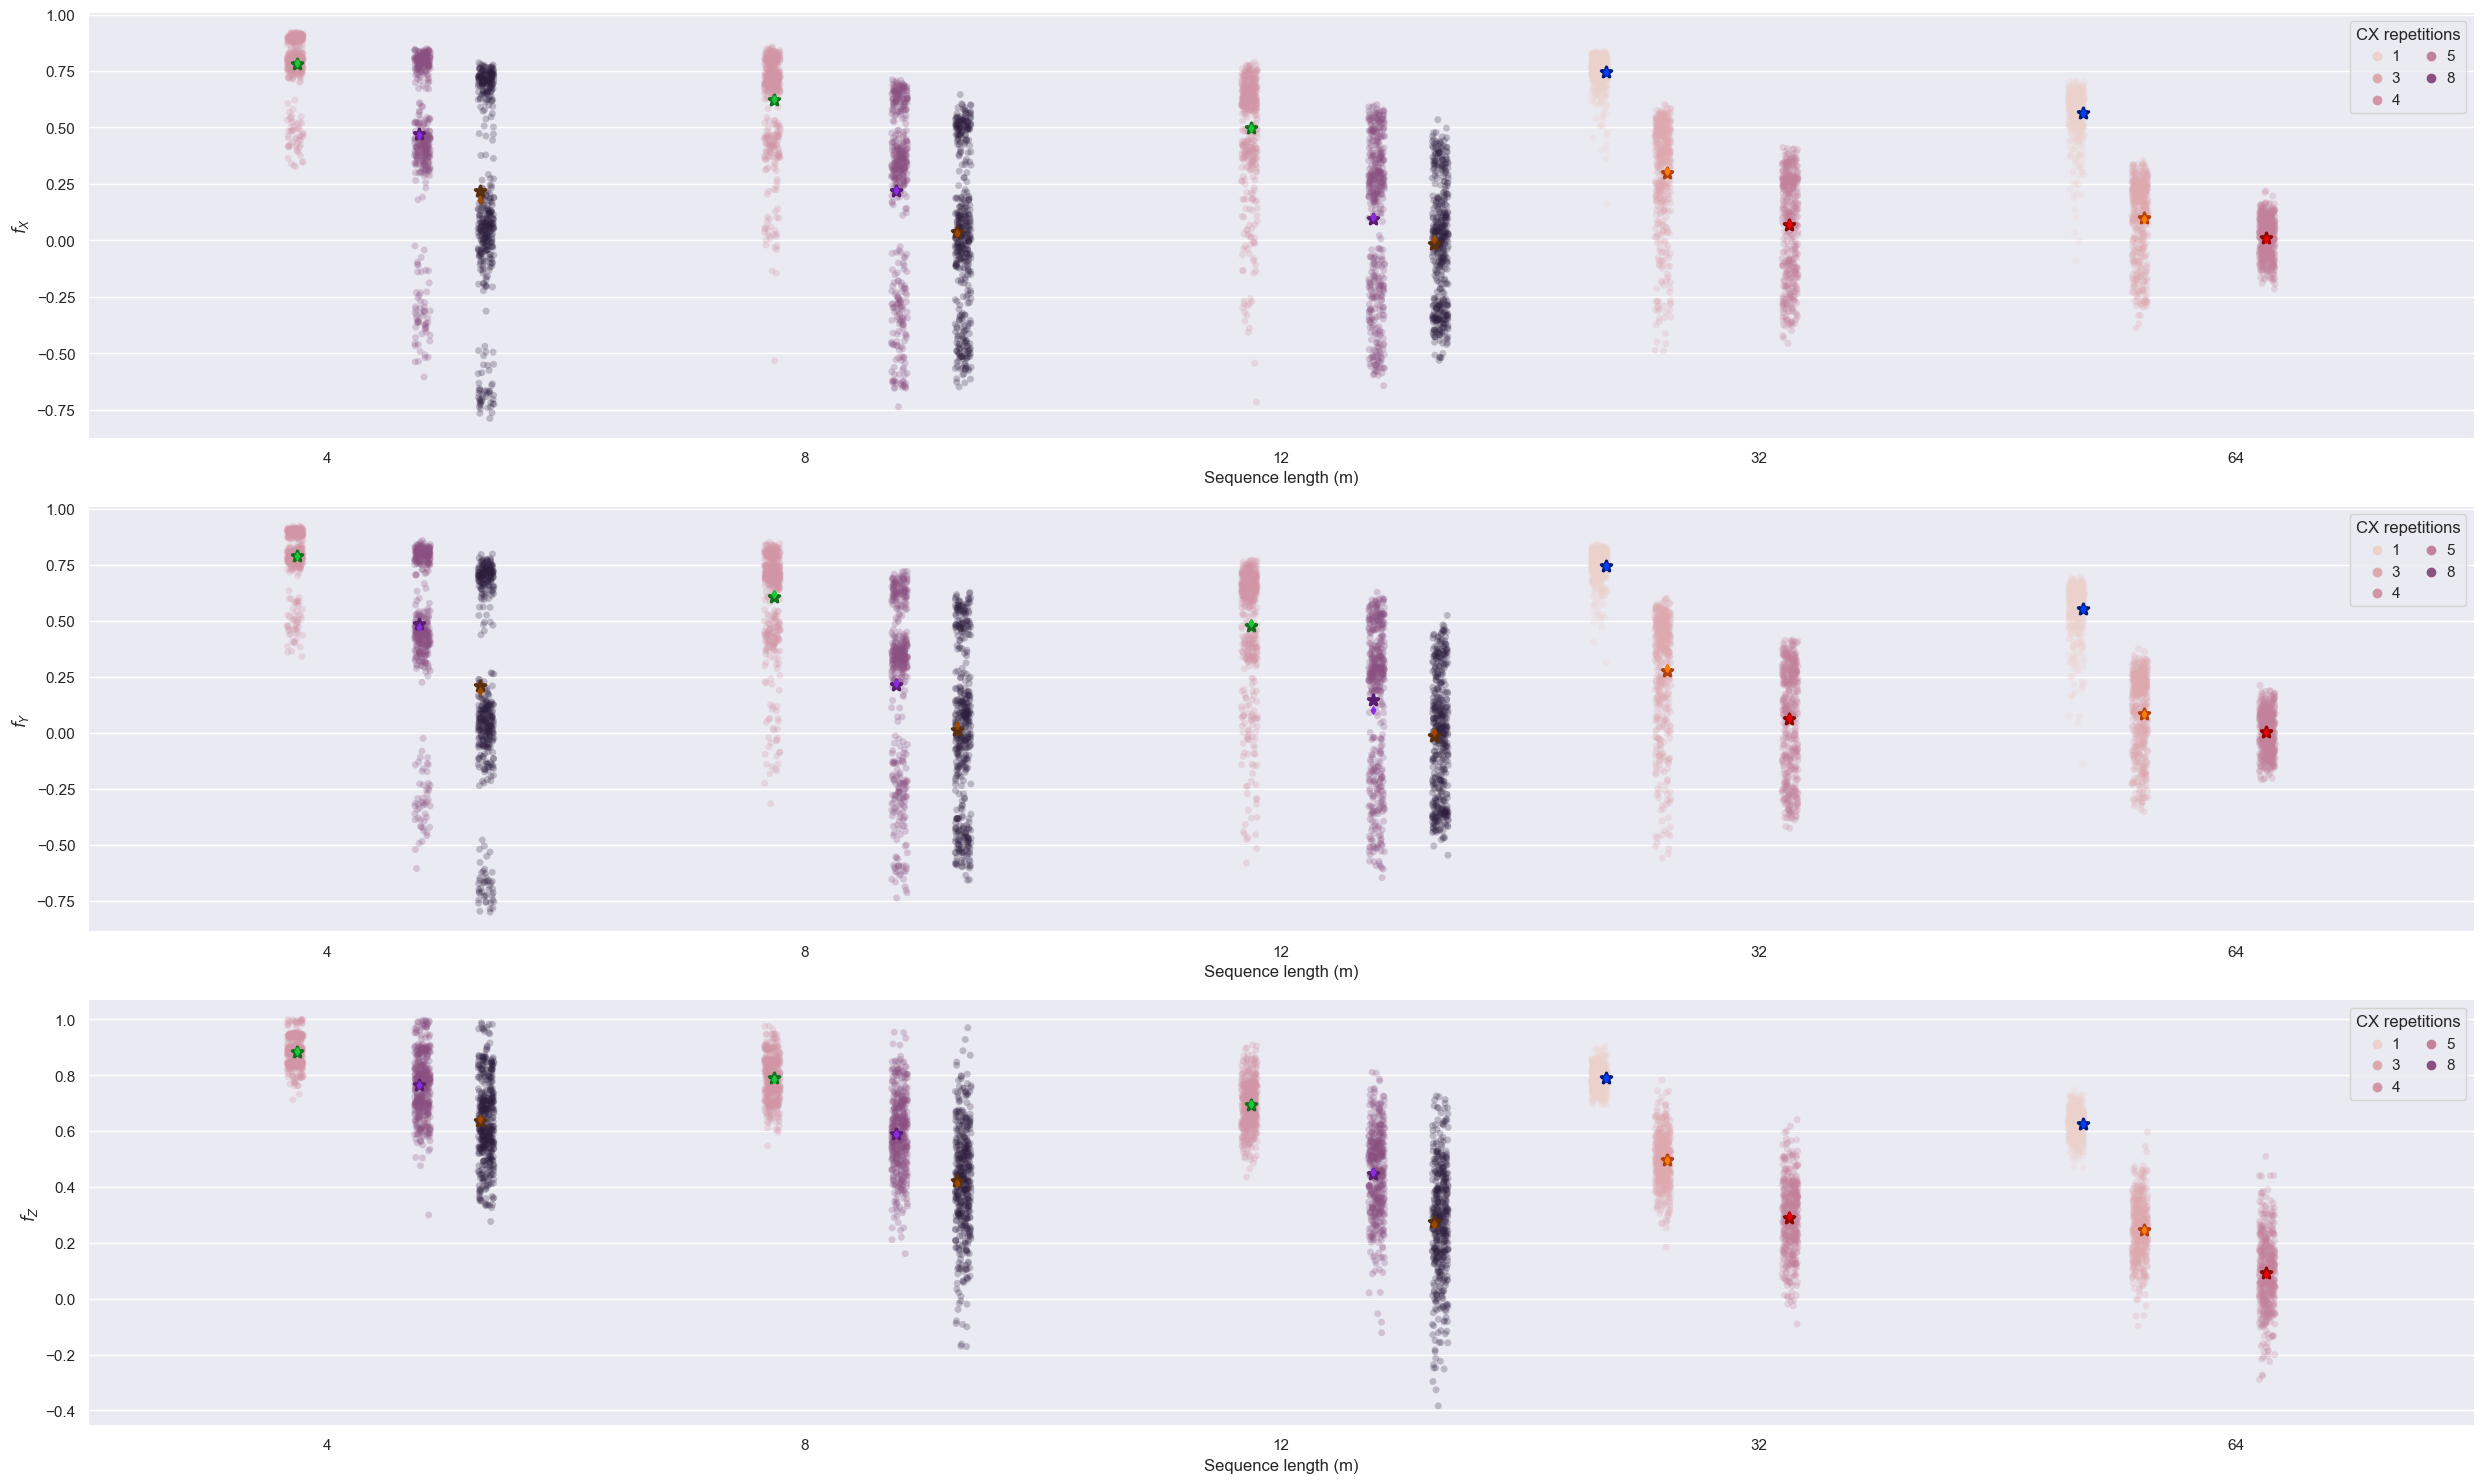

In [157]:
sns.set() # textwidth is 6.13899in
sns.set_theme("notebook", palette="deep", style='darkgrid')
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(25, 15))
pauli2ax = {'X': ax1, 'Y': ax2, 'Z': ax3}
for pauli in ['X', 'Y', 'Z']:
    # Initialize the figure
    sns.despine(bottom=True, left=True)

    # Show each observation with a scatterplot
    sns.stripplot(x="n_random_cycles", y="fidelity", hue="rep",
                  data=results_df[results_df['Pauli'] == pauli], dodge=True, alpha=.25, zorder=1, ax=pauli2ax[pauli])

    # Show the conditional means, aligning each pointplot in the
    # center of the strips by adjusting the width allotted to each
    # category (.8 by default) by the number of hue levels
    sns.pointplot(x="n_random_cycles", y="fidelity", hue="rep",
                  data=results_df[results_df['Pauli'] == pauli], dodge=.8 - .8 / 5,
                  join=False, palette="dark",
                  markers="*", scale=1.15, errorbar=None, ax=pauli2ax[pauli])

    sns.pointplot(x="n_random_cycles", y="fidelity", hue="rep",
                  data=df_fit_full[df_fit_full['Pauli'] == pauli], dodge=.8 - .8 / 5,
                  join=False, palette="bright",
                  markers="d", scale=.55, errorbar=None, ax=pauli2ax[pauli])

    # Improve the legend
    handles, labels = pauli2ax[pauli].get_legend_handles_labels()
    pauli2ax[pauli].legend(handles[0:5], labels[0:5], title="CX repetitions",
              handletextpad=0, columnspacing=1,
              loc="best", ncol=2, frameon=True)
    plt.tight_layout()
    pauli2ax[pauli].set_ylabel(r'$f_'+pauli+'$')
    pauli2ax[pauli].set_xlabel(r'Sequence length (m)')


In [147]:
# date_str = 20240115
# x, y = 268053, 0.0001, 0.0001
# x, y = 662030, 0.001, 0.001
# x, y = 17961, 0.001, 0.0001
# x = 820082, 0.001
# y = 354368, 0.001
# x, y = 785447, 0.001, 0.001

# date_str = 20240118
# x, y = 417855, 0.00005, 0.00005
# x, y = 604052, 0.0001, 0.0001

id = "882106"

dl = DataLogger(directory=f"./simulations/20240115/{id}/")
exp_info = dl.read_data()

rep_len_tuples = ast.literal_eval(exp_info["rep_len_tuples"])
 
 
cer_circuits = tq.load(F"./simulations/20240115/{id}/executed_circuits.tq")

In [148]:
results_df = extract_results_dataframe(cer_circuits, ast.literal_eval(exp_info["rep_len_tuples"]), qubit_index=qubit_index)
avg_df = extract_avg_dataframe(results_df, ast.literal_eval(exp_info["rep_len_tuples"]), confidence=0.682)


In [149]:
fid_fit = []
rep_fit = []
length_fit = []
residual = []
decay = []
upper_bound_tw = 1.  # 1.00

# Fit to the full model
est_full, cov_full = curve_fit(f=error_model,
                               ydata=avg_df['fidelity'],
                               xdata=[avg_df['n_random_cycles'],
                                      avg_df['rep'], avg_df['Pauli_num']],  # [m, x]
                               sigma=avg_df['fidelity_std'],
                               p0=[1, 0, 0, 0]*3,
                               bounds=[[0, 0, 0, 0]*3,
                                       [1, 1, 1, upper_bound_tw]*3],
                               method='trf')

# Generate fitted fidelities (the stars)
for (rep, length) in rep_len_tuples:
    for pauli in ['X', 'Y', 'Z']:
        pauli_num = PAULITONUM[pauli]

        data_fid = avg_df[(avg_df['n_random_cycles'] == length)
                        & (avg_df['rep'] == rep)
                        & (avg_df['Pauli_num'] == pauli_num)]['fidelity']
        fit_fid = float(error_model([length, rep, [pauli_num]],
                                   *est_full
                                   ))
        fid_fit.append(fit_fid)
        residual.append(fit_fid-data_fid)
        rep_fit.append(rep)
        length_fit.append(length)
        decay.append(pauli)

# Generate a dataframe for the fitted fidelity values:
df_dict = {'fidelity': fid_fit,
           'rep': rep_fit,
           'n_random_cycles': length_fit,
           'Pauli': decay,
           'residual': residual}
df_fit_full = pd.DataFrame(data=df_dict)  # Corresponds to the stars

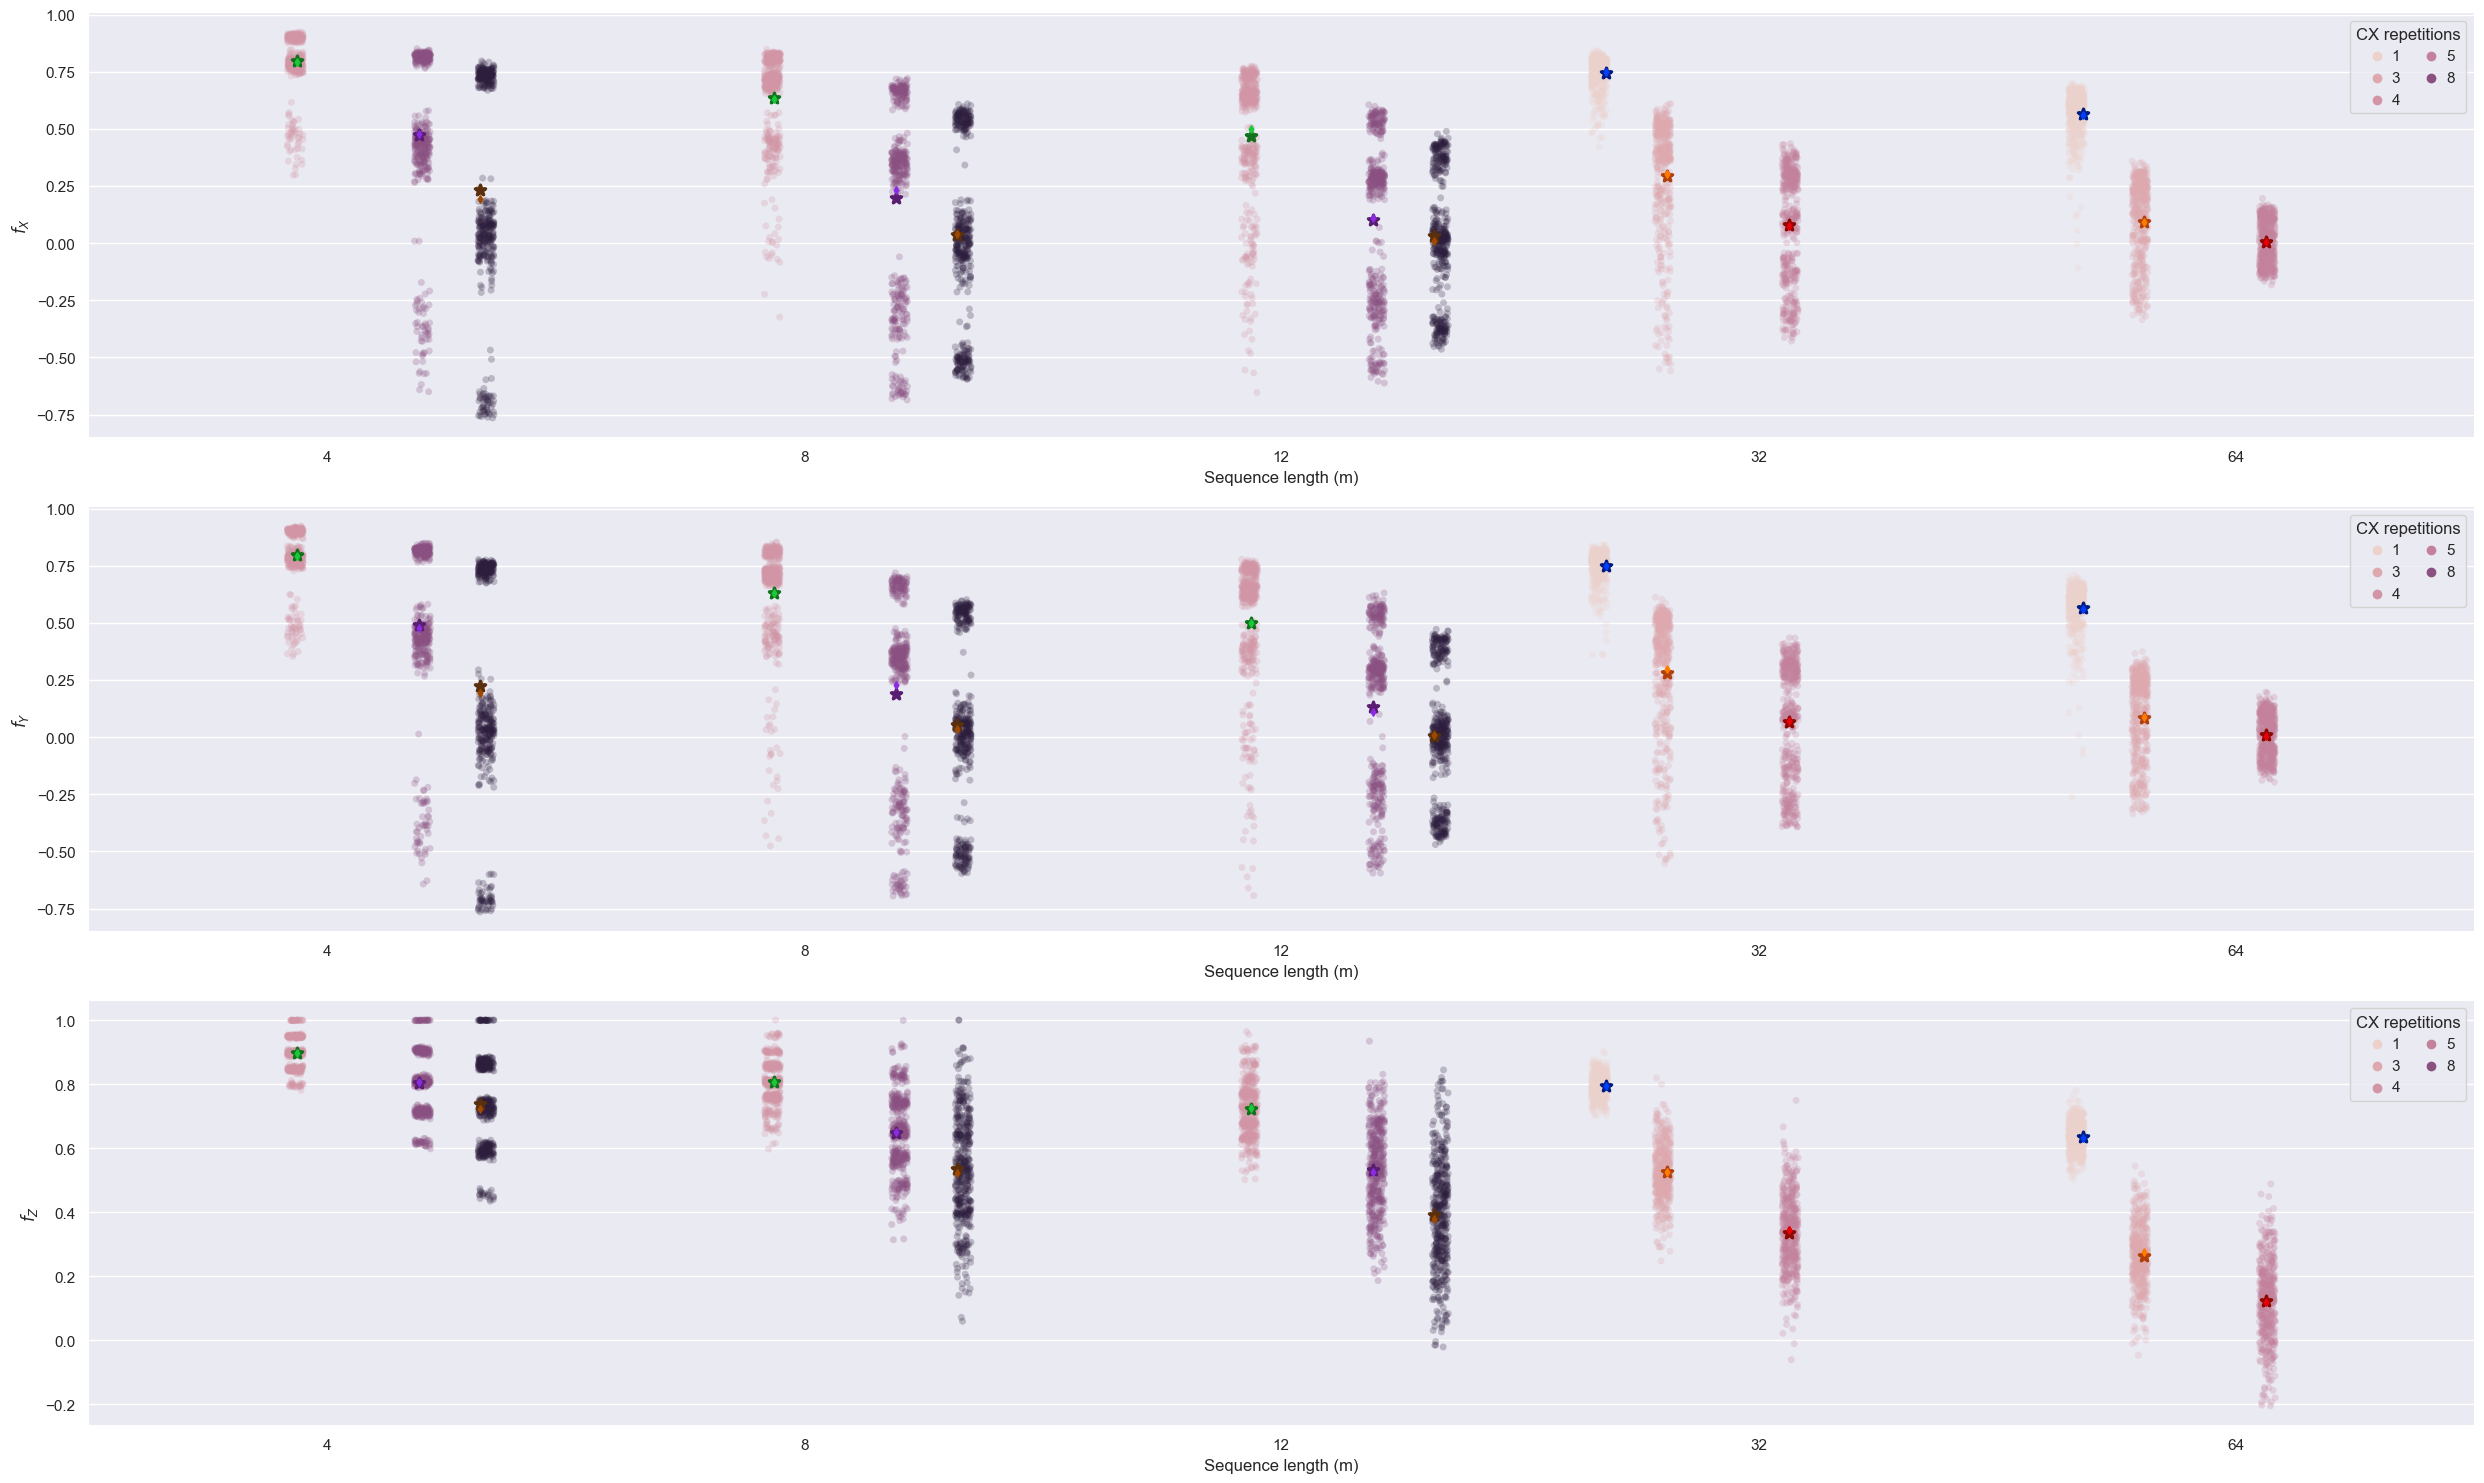

In [150]:
sns.set() # textwidth is 6.13899in
sns.set_theme("notebook", palette="deep", style='darkgrid')
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(25, 15))
pauli2ax = {'X': ax1, 'Y': ax2, 'Z': ax3}
for pauli in ['X', 'Y', 'Z']:
    # Initialize the figure
    sns.despine(bottom=True, left=True)

    # Show each observation with a scatterplot
    sns.stripplot(x="n_random_cycles", y="fidelity", hue="rep",
                  data=results_df[results_df['Pauli'] == pauli], dodge=True, alpha=.25, zorder=1, ax=pauli2ax[pauli])

    # Show the conditional means, aligning each pointplot in the
    # center of the strips by adjusting the width allotted to each
    # category (.8 by default) by the number of hue levels
    sns.pointplot(x="n_random_cycles", y="fidelity", hue="rep",
                  data=results_df[results_df['Pauli'] == pauli], dodge=.8 - .8 / 5,
                  join=False, palette="dark",
                  markers="*", scale=1.15, errorbar=None, ax=pauli2ax[pauli])

    sns.pointplot(x="n_random_cycles", y="fidelity", hue="rep",
                  data=df_fit_full[df_fit_full['Pauli'] == pauli], dodge=.8 - .8 / 5,
                  join=False, palette="bright",
                  markers="d", scale=.55, errorbar=None, ax=pauli2ax[pauli])

    # Improve the legend
    handles, labels = pauli2ax[pauli].get_legend_handles_labels()
    pauli2ax[pauli].legend(handles[0:5], labels[0:5], title="CX repetitions",
              handletextpad=0, columnspacing=1,
              loc="best", ncol=2, frameon=True)
    plt.tight_layout()
    pauli2ax[pauli].set_ylabel(r'$f_'+pauli+'$')
    pauli2ax[pauli].set_xlabel(r'Sequence length (m)')
